<a href="https://colab.research.google.com/github/musharrafhamraz/Machine-Learning-Algo-s/blob/main/Computer_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib as plt
import numpy as np

In [3]:
import os
from os.path import split
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!7za -y x "/content/drive/MyDrive/data"


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 
ERROR: No more files
/content/drive/MyDrive/data



System ERROR:
Unknown error -2147024872


In [5]:
!ls '/content/drive/MyDrive/Colab Notebooks/data'

image  label


In [6]:
!7za -y x' /content/drive/MyDrive/Colab Notebooks/data/image/origin.7z.001'


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)



Command Line Error:
Unsupported command:
x /content/drive/MyDrive/Colab Notebooks/data/image/origin.7z.001


In [7]:
!pip install pillow

In [8]:
!ls '/content/drive/MyDrive/Colab Notebooks/data/image'

origin.7z.001  origin.7z.003  origin.7z.005  origin.7z.007
origin.7z.002  origin.7z.004  origin.7z.006  origin.7z.008


In [9]:
!7z x '/content/drive/MyDrive/Colab Notebooks/data/image/origin.7z.001'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/Colab Notebooks/data/image/                                                            1 file, 1048576000 bytes (1000 MiB)

Extracting archive: /content/drive/MyDrive/Colab Notebooks/data/image/origin.7z.001
  0% 1 Open           --
Path = /content/drive/MyDrive/Colab Notebooks/data/image/origin.7z.001
Type = Split
Physical Size = 1048576000
Volumes = 8
Total Physical Size = 8113576419
----
Path = origin.7z
Size = 8113576419
--
Path = origin.7z
Type = 7z
Physical Size = 8113576419
Headers Size = 863607
Method = LZMA:25
Solid = +
Blocks = 2

  0%      0% - origin/afraid_African_21

In [11]:
label_file_name="//content/drive/MyDrive/Colab Notebooks/data/label/label.lst"
image_file_name="/content/drive/MyDrive/origin "

In [18]:
df_info= pd.read_csv(label_file_name, sep=" ", header=None)

col_names = "image_name face_id_in_image face_box_top face_box_left face_box_right face_box_bottom face_box_confidence expression_label".split()

df_info.columns = col_names
data_path = "/content/drive/MyDrive/origin"
# Taking a glance at the data
df_info.head()

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_confidence,expression_label
0,angry_actor_104.jpg,0,28,113,226,141,22.9362,0
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,0
2,angry_actor_120.jpg,1,53,53,372,372,13.9434,2
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,3
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,0


In [13]:
df_info.to_csv('/content/drive/MyDrive/df.csv', index=False)

In [14]:
df_verify = pd.read_csv('/content/drive/MyDrive/df.csv')

In [20]:
df_sel = df_info[df_info.face_box_confidence > 30]

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


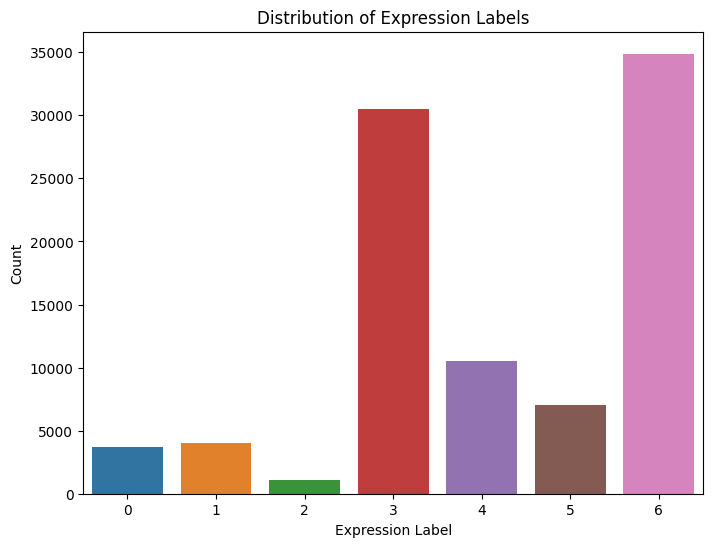

In [28]:
plt.figure(figsize=(8, 6))
sns.countplot(x='expression_label', data=df_info)
plt.xlabel('Expression Label')
plt.ylabel('Count')
plt.title('Distribution of Expression Labels')
plt.show()

In [29]:
img_lst =[]
lable_lst = []

In [30]:
for i, row in df_sel.sample(5000).iterrows():
    img_name = row["image_name"]
    x1 = row["face_box_left"]
    x2 = row["face_box_right"]
    y1 = row["face_box_top"]
    y2 = row["face_box_bottom"]
    label = row["expression_label"]
    img_path = os.path.join(image_file_name, img_name)
    img = cv2.imread(img_path)
    # Check if img is not None
    if img is not None:
        # Crop the image using the provided coordinates
        cropped_img = img[y1:y2, x1:x2]
    else:
        continue

    if cropped_img is not None:
        # Resize the cropped image to a fixed size (e.g., 64x64)
        resized_face = cv2.resize(cropped_img, (64, 64))
    else:
        continue

    # Normalize the image data (scaling pixel values to the range [0, 1])
    normalized_face = resized_face / 255.0
    img_lst.append(normalized_face)
    lable_lst.append(label)

In [32]:
import numpy as np

In [34]:
X = np.array(img_lst)
Y = np.array(lable_lst)

In [36]:
print("shape of images" , X.shape)
print("shape of lables" , Y.shape)

shape of images (281, 64, 64, 3)
shape of lables (281,)


In [37]:
#the data will be splitted here to tran and test set

from sklearn.model_selection import train_test_split


X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Training set size: 196
Validation set size: 42
Testing set size: 43


In [38]:
from keras.utils import to_categorical

Y_train_one_hot = to_categorical(Y_train, num_classes=7)
Y_val_one_hot = to_categorical(Y_val, num_classes=7)
Y_test_one_hot = to_categorical(Y_test, num_classes=7)

In [39]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [41]:
my_model = Sequential()

my_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
my_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))
my_model.add(Dropout(0.25))

my_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))
my_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))
my_model.add(Dropout(0.25))

my_model.add(Flatten())
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(7, activation='softmax'))

In [42]:
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                    

In [44]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(X_train)

In [46]:
from keras.callbacks import TensorBoard

log_dir = "/content/drive/MyDrive/project/logs"
tensorboard_callback = TensorBoard(log_dir=log_dir)

# Train the model using the augmented data and TensorBoard callback
history = my_model.fit(datagen.flow(X_train, Y_train_one_hot, batch_size=32),
                            epochs=200,
                            validation_data=(X_val, Y_val_one_hot),
                            callbacks=[tensorboard_callback])

Epoch 1/200
7/7 [==============================] - 1s 83ms/step - loss: 0.7695 - accuracy: 0.6786 - val_loss: 2.3612 - val_accuracy: 0.5476
Epoch 2/200
7/7 [==============================] - 0s 57ms/step - loss: 0.7250 - accuracy: 0.6786 - val_loss: 2.2250 - val_accuracy: 0.5238
Epoch 3/200
7/7 [==============================] - 0s 54ms/step - loss: 0.7534 - accuracy: 0.6939 - val_loss: 2.3675 - val_accuracy: 0.5952
Epoch 4/200
7/7 [==============================] - 0s 48ms/step - loss: 0.8124 - accuracy: 0.6582 - val_loss: 2.2734 - val_accuracy: 0.5238
Epoch 5/200
7/7 [==============================] - 0s 48ms/step - loss: 0.8448 - accuracy: 0.6429 - val_loss: 2.3334 - val_accuracy: 0.5476
Epoch 6/200
7/7 [==============================] - 0s 46ms/step - loss: 0.7319 - accuracy: 0.7296 - val_loss: 2.1069 - val_accuracy: 0.5238
Epoch 7/200
7/7 [==============================] - 0s 53ms/step - loss: 0.7494 - accuracy: 0.7143 - val_loss: 2.1390 - val_accuracy: 0.5476
Epoch 8/200
7/7 [===

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [48]:
Y_pred_one_hot = my_model.predict(X_test)
Y_pred = np.argmax(Y_pred_one_hot, axis=1)

2/2 [==============================] - 0s 208ms/step


In [49]:
Y_test_true = np.argmax(Y_test_one_hot, axis=1)

In [50]:
# Calculate the confusion matrix
cm = confusion_matrix(Y_test_true, Y_pred)

In [51]:
model_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

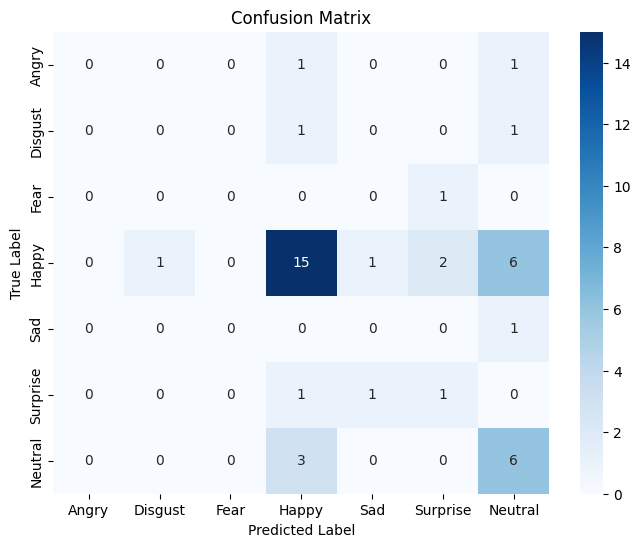

In [52]:
# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model_labels, yticklabels=model_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()